In [1]:
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt

In [36]:
_eps = np.exp(-16)#1e-16 #np.exp(-16) #1e-16

def log(x):
    return np.log(x + _eps)

def softmax(x):
    # stable softmax
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def jsoftmax(x):
    # stable softmax
    e_x = jnp.exp(x - jnp.max(x))
    return e_x / e_x.sum(axis=0)

In [3]:
# The A matrix represents generative model's "prior beliefs" about the relationship between hidden states and observations or how the hidden states generate observations
# columns are states, rows are observations/outputs

# (n_states, n_observations)
A = np.asarray([
    [7, 1, 1, 1],
    [1, 7, 1, 1],
    [1, 1, 7, 1],
    [1, 1, 1, 7],
]) / 10
# in the first state, there's a 70% chance of playing the first note, and a 10% chance of playing any other note (There's a 70% if the first note is played that the first state is the cause)
# in the second state, there's a 70% chance of playing the second note, and a 10% chance of playing any other note
# in the third state, there's a 70% chance of playing the third note, and a 10% chance of playing any other note
# in the fourth state, there's a 70% chance of playing the fourth note, and a 10% chance of playing any other note

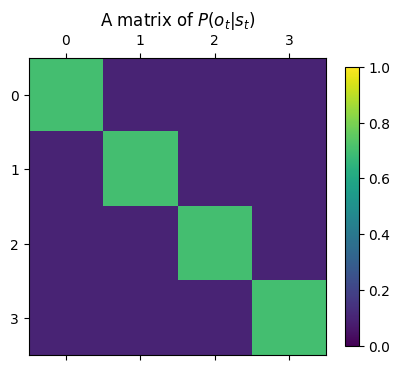

In [4]:
plt.matshow(A, vmin = 0.0, vmax = 1.0)
plt.title("A matrix of $P(o_t | s_t)$")
plt.colorbar(shrink=0.75)
plt.show()

In [5]:
# The B matrix represents the generative model's "prior beliefs" about the relationship between transitions between hidden states over time
# columns are current states, rows are the next state. B[next_state][current_state] #TODO: check this
B = np.asarray([
    [1, 1, 1, 97],
    [97, 1, 1, 1],
    [1, 97, 1, 1],
    [1, 1, 97, 1],
]) / 100
# There's  a 97% chance of transitioning from the first state to the second state 
# There's a 97% chance of transitioning from the second state to the third state
# There's a 97% chance of transitioning from the third state to the fourth state
# There's a 97% chance of transitioning from the fourth state to the first state

In [79]:
np.array([0, 1, 0, 0]) * B 

array([[0],
       [1],
       [0],
       [0]])

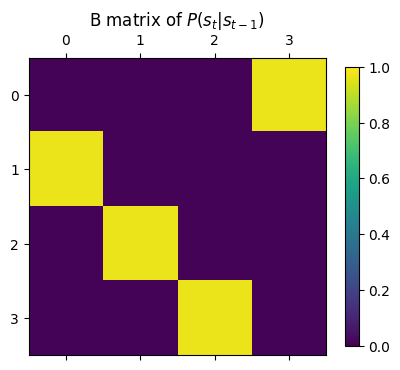

In [6]:
plt.matshow(B, vmin = 0.0, vmax = 1.0)
plt.title("B matrix of $P(s_t | s_{t-1})$")
plt.colorbar(shrink=0.75)
plt.show()

In [7]:
# Prior probabilities of the notes (always start with the first note)
D = np.asarray([
    1, 0, 0, 0
    # [1], 
    # [0],
    # [0], 
    # [0]
])
# Agent beliefs they are at position 0 with 100% certainty

$$ \begin{align} q(s_t) = \sigma\left(\ln \mathbf{A}[o,:] + \ln\mathbf{B}[:,:,u] \cdot q(s_{t-1})\right) \end{align} $$

$$
Q(s|\pi) = \prod_{\tau} Q(s_{\tau}|\pi)
$$

$$ \begin{align} P(s_t) = \mathbf{E}{q(s{t-1})}\left[P(s_t | s_{t-1}, u_{t-1})\right] \end{align} $$

[array([1., 0., 0., 0.]), array([0., 1., 0., 0.]), array([0., 1., 0., 0.]), array([0., 0., 0., 1.]), array([1., 0., 0., 0.])]


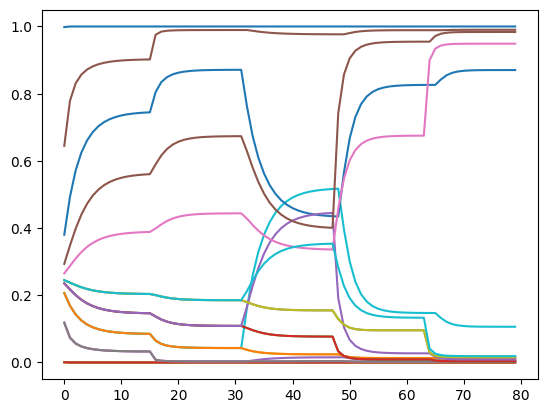

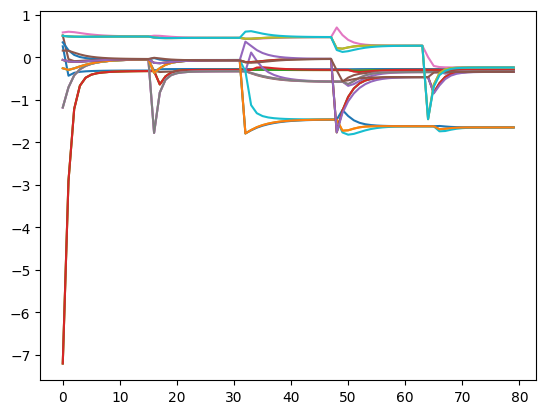

In [61]:
# A = [
#     light_blue_shapes_os,
#     light_green_shapes_os
# ]

# B = [
#     light_blue_shapes_ts,
#     light_green_shapes_ts
# ]

# transpose the transition matrices and normalize the columns
B_T = B .T /  B .T.sum(axis =0)


# D = [
#     light_blue_shapes_ps,
#     light_green_shapes_ps
# ]

out_indices = [0, 1, 1, 3, 0]

outs = [np.zeros((len(D),)) for _ in range(len(out_indices))]
for i, out_index in enumerate(out_indices):
    outs[i][out_index] = 1

print(outs)

# num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

tau = .75

qs_arr = np.ones((time_steps, len(D))) / len(D)

qs_history = np.zeros((time_steps, num_iter, time_steps, 4))

err_history = np.zeros((time_steps, num_iter, time_steps, 4))

# for each time step (over all observations)
for t in range(time_steps):
    # for each factor (light blue shapes, light green shapes)
    # for f in range(num_factors):
    # refine the approximate posterior over num_iter iterations
    for i in range(num_iter):
        # for each time step (over all observations)
        for tt in range(time_steps):
            if tt <= t:
                log_A = log(A.T  @ outs[tt] )
            else:
                log_A = 0
                
            v = log(qs_arr[tt])

            if tt == 0:
                log_B_past = log(D)
            else:
                log_B_past = log(B @ qs_arr[tt - 1])

            if tt == time_steps - 1:
                log_B_future = 0
            else:
                log_B_future = log(B_T @ qs_arr[tt + 1])

            err = 0.5 * (log_B_past + log_B_future) + log_A - v
            err *= tau
    
            v = v + err

            qs_arr[tt] = softmax(v)

            qs_history[t, i, tt] = qs_arr[tt]
            err_history[t, i, tt] = err

full_beliefs = []
for t in range(time_steps):
    for i in range(num_iter):
        full_beliefs.append(qs_history[t][i].flatten())

full_beliefs = np.asarray(full_beliefs)

plt.ylim(-0.05, 1.05)
plt.plot(full_beliefs)
plt.show()

full_errors = []
for t in range(time_steps):
    for i in range(num_iter):
        full_errors.append(err_history[t][i].flatten())

full_errors = np.asarray(full_errors)

# plt.ylim(-0.05, 1.05)
plt.plot(full_errors)
plt.show()

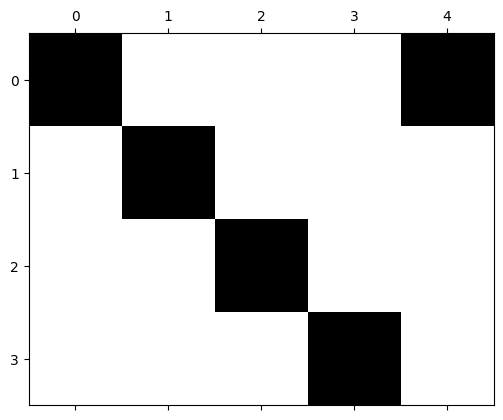

In [38]:
plt.matshow(qs_arr.T, vmin = 0.0, vmax = 1.0, cmap = 'binary')

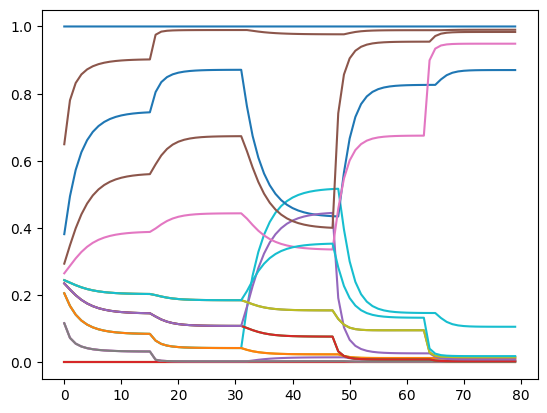

In [10]:
full_beliefs = []
for t in range(time_steps):
    for i in range(num_iter):
        full_beliefs.append(qs_history[t][i].flatten())

full_beliefs = np.asarray(full_beliefs)

plt.ylim(-0.05, 1.05)
plt.plot(full_beliefs)
plt.show()

In [11]:
eps_ = 1e-16

out_index = 0
# qs_past = [[1], [0], [0], [0]]
qs_past = np.asarray([.97, 0.01, 0.01, 0.01]) 
prior = np.asarray([1, 0, 0, 0])
print("prior", prior)

log_likelihood = np.log(A[:, out_index] + eps_)
print(A[1])
print(log_likelihood)
log_prior = np.log(prior + eps_)
print(log_prior)
qs = softmax(log_likelihood + log_prior)

initial_f = qs_past.dot(np.log(qs_past + eps_) - (log_likelihood + log_prior))
print(initial_f)

A

prior [1 0 0 0]
[0.1 0.7 0.1 0.1]
[-0.35667494 -2.30258509 -2.30258509 -2.30258509]
[  0.         -36.84136149 -36.84136149 -36.84136149]
1.3525925562077241


array([[0.7, 0.1, 0.1, 0.1],
       [0.1, 0.7, 0.1, 0.1],
       [0.1, 0.1, 0.7, 0.1],
       [0.1, 0.1, 0.1, 0.7]])

In [64]:
from jax import grad
from jax import numpy as jnp


def variational_free_energy(qs, obs_likelihood, obs_given_state_likelihood, prior):
    # print("obs_likelihood", obs_likelihood)
    # print("obs_given_state_likelihood", obs_given_state_likelihood)
    state_likelihood = obs_given_state_likelihood.dot(obs_likelihood)
    # print("state_likelihood", state_likelihood)

    log_joint_likelihood = jnp.log(state_likelihood * prior + eps_)

    variational_free_energy = qs.dot(jnp.log(qs + eps_) - log_joint_likelihood)

    return variational_free_energy


grad_variational_free_energy = grad(variational_free_energy)

# number of iterations of gradient descent to perform
n_iter = 40

D = np.asarray([0.5, 0.5, 0.5, 0.5]) #
D = np.asarray([1, 0, 0, 0]) #
prior = D

qs_past = np.asarray([.97, 0.01, 0.01, 0.01]) 
qs_past = softmax(np.asarray([.5, 0.5, 0.5, 0.5])) 

qs_hist = np.zeros((n_iter, 4))
qs_hist[0,:] = qs_past

# qs_hist = qs_hist.at[idx].set(y

vfe_hist = np.zeros(n_iter)

out = np.zeros(4)
out[0] = 1



vfe_hist[0] = variational_free_energy(qs_past, out, A, prior)

learning_rate = 0.01 # learning rate to prevent gradient steps that are too big (overshooting)
for i in range(n_iter-1):   

    print("qs_hist[i,:]", qs_hist[i,:])
    print("out", out)
    print("A", A)
    print("prior", prior)
    dFdqs = grad_variational_free_energy(qs_hist[i,:], out, A, prior)


    ln_qs = jnp.log(qs_hist[i,:]) - learning_rate * dFdqs # transform qs to log-space to perform gradient descent

    print("dFdqs", dFdqs)
    # print(np.exp(dFdqs))
    qs_hist[i+1,:] = softmax(ln_qs) # re-normalize to make it a proper, categorical Q(s) again

    vfe_hist[i+1] = variational_free_energy(qs_hist[i+1,:], out, A, prior) # measure final variational free energy

    break


qs_hist[i,:] [0.25 0.25 0.25 0.25]
out [1. 0. 0. 0.]
A [[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]
prior [1 0 0 0]
dFdqs [-2.9619455e-02  3.6455067e+01  3.6455067e+01  3.6455067e+01]


qs_hist[i,:] [0.25 0.25 0.25 0.25]
out [1. 0. 0. 0.]
A [[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]
prior [1 0 0 0]
dFqs [-2.9619455e-02  3.6455067e+01  3.6455067e+01  3.6455067e+01]
[-1.3859981 -1.750845  -1.750845  -1.750845 ]
[0.32436895 0.22521035 0.22521035 0.22521035]

qs_hist[i,:] [0.25 0.25 0.25 0.25]
out [1. 0. 0. 0.]
A [[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]
prior [0.21862697 0.34411909 0.21862697 0.21862697]
dFqs [1.4907689 2.9830582 3.4366791 3.4366791]
[-1.4012021 -1.4161249 -1.4206612 -1.4206612]
[0.2533797  0.24962664 0.2484968  0.2484968 ]

qs_hist[i,:] [0.25 0.25 0.25 0.25]
out [1. 0. 0. 0.]
A [[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]
prior [0.24827627 0.25388462 0.24956284 0.24827627]
dFqs [1.3635937 3.287166  3.3043354 3.3095038]
[-1.3999304 -1.419166  -1.4193377 -1.4193894]
[0.25364894 0.24881648 0.24877372 0.24876089]

qs_hist[i,:] [0.25 0.25 0.25 0.25]
out [1. 0

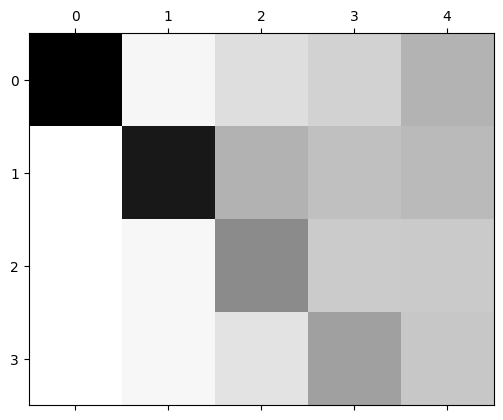

In [70]:
from jax import grad
from jax import numpy as jnp


def variational_free_energy(qs, obs_likelihood, obs_given_state_likelihood, prior):
    # print("obs_likelihood", obs_likelihood)
    # print("obs_given_state_likelihood", obs_given_state_likelihood)
    state_likelihood = obs_given_state_likelihood.dot(obs_likelihood)
    # print("state_likelihood", state_likelihood)

    log_joint_likelihood = jnp.log(state_likelihood * prior + eps_)

    variational_free_energy = qs.dot(jnp.log(qs + eps_) - log_joint_likelihood)

    return variational_free_energy


grad_variational_free_energy = grad(variational_free_energy)

# number of iterations of gradient descent to perform
n_iter = 100

D = np.asarray([0.5, 0.5, 0.5, 0.5]) #
D = np.asarray([1, 0, 0, 0]) #
prior = D

qs_past = np.asarray([.97, 0.01, 0.01, 0.01]) 
qs_past = softmax(np.asarray([.5, 0.5, 0.5, 0.5])) 

qs_hist = np.zeros((n_iter, 4))
qs_hist[0,:] = qs_past

qs_arr = np.ones((time_steps, len(D))) / len(D)

qs_history = np.zeros((time_steps, num_iter, time_steps, 4))


# qs_hist = qs_hist.at[idx].set(y

vfe_hist = np.zeros(n_iter)

out = np.zeros(4)
out[0] = 1

t = time_steps

vfe_hist[0] = variational_free_energy(qs_past, out, A, prior)

learning_rate = 0.01 # learning rate to prevent gradient steps that are too big (overshooting)
# for each time step (over all observations)
for t in range(time_steps):
    # for each factor (light blue shapes, light green shapes)
    # for f in range(num_factors):
    # refine the approximate posterior over num_iter iterations
    for i in range(num_iter):
        # for each time step (over all observations)
        for tt in range(time_steps):
            
            if tt <= t:
                out = np.zeros(4)
                out[out_indices[tt]] = 1

                log_A = log(A.T  @ out )
            else:
                log_A = 0

            if tt == 0:
                log_B_past = D
            else:
                log_B_past = softmax(log(B) @ qs_arr[tt - 1])

            print("qs_hist[i,:]", qs_arr[tt])
            print("out", out)
            print("A", A)
            print("prior", log_B_past)
            dFdqs = grad_variational_free_energy(qs_arr[tt], out, A, log_B_past)

            print("dFqs", dFdqs)

            ln_qs = jnp.log(qs_arr[tt] + eps_) - learning_rate * dFdqs # transform qs to log-space to perform gradient descent

            print(ln_qs)

            qs_arr[tt] = softmax(ln_qs) # re-normalize to make it a proper, categorical Q(s) again

            print(qs_arr[tt])

            print()

            qs_history[t, i, tt] = qs_arr[tt]

plt.matshow(qs_arr.T, vmin = 0.0, vmax = 1.0, cmap = 'binary')

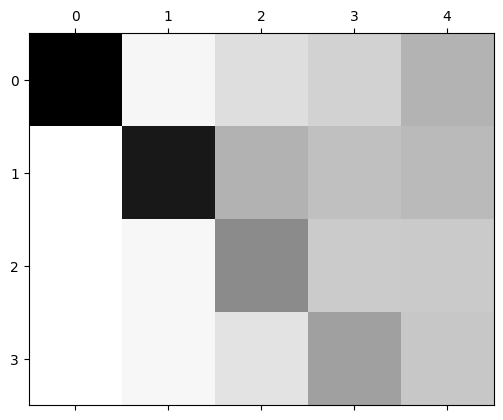

In [69]:
plt.matshow(qs_arr.T, vmin = 0.0, vmax = 1.0, cmap = 'binary')

In [14]:
qs_hist

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.32436895, 0.22521035, 0.22521035, 0.22521035],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        ,

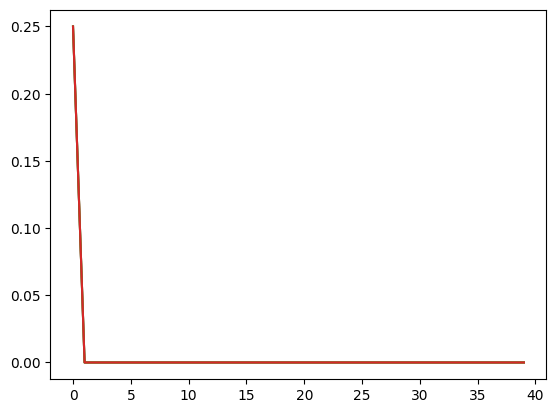

In [57]:
plt.plot(qs_hist)

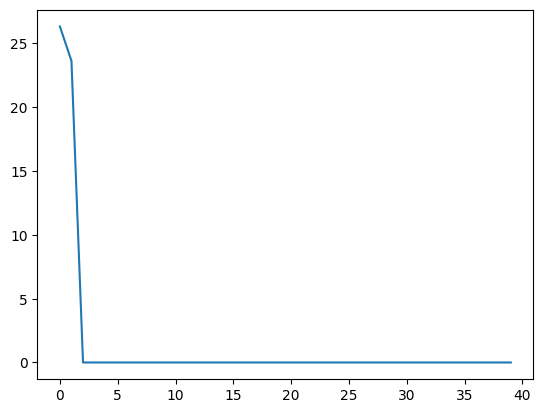

In [16]:
plt.plot(vfe_hist)

In [17]:
B.dot([9.99982834e-01, 5.68614223e-06, 5.68614223e-06, 5.68614223e-06])

array([0.01000546, 0.96998352, 0.01000546, 0.01000546])

In [18]:
D = [1, 0, 0, 0]

0 [-1.3851095 -2.844497  -2.844497  -2.844497 ]
1 [-0.5620513 -3.4224508 -3.4224508 -3.4224508]
2 [-0.20641522 -4.411786   -4.411786   -4.411786  ]
3 [-0.09628957 -5.592833   -5.592833   -5.592833  ]
4 [-0.06600556 -6.8020744  -6.8020744  -6.8020744 ]
5 [-0.05768042 -7.983694   -7.983694   -7.983694  ]
6 [-0.05530668 -9.123668   -9.123668   -9.123668  ]
7 [ -0.05459893 -10.219614   -10.219614   -10.219614  ]
8 [ -0.0543779 -11.27218   -11.27218   -11.27218  ]
9 [ -0.0543058 -12.282783  -12.282783  -12.282783 ]
10 [ -0.05428107 -13.253006   -13.253006   -13.253006  ]
11 [ -0.05427249 -14.184436   -14.184436   -14.184436  ]
12 [ -0.05426906 -15.078613   -15.078613   -15.078613  ]
13 [ -0.05426803 -15.937026   -15.937026   -15.937026  ]
14 [ -0.05426734 -16.761103   -16.761103   -16.761103  ]
15 [ -0.054267 -17.552216 -17.552216 -17.552216]
16 [ -0.054267 -18.311684 -18.311684 -18.311684]
17 [ -0.054267 -19.040773 -19.040773 -19.040773]
18 [ -0.054267 -19.7407   -19.7407   -19.7407  ]
19 

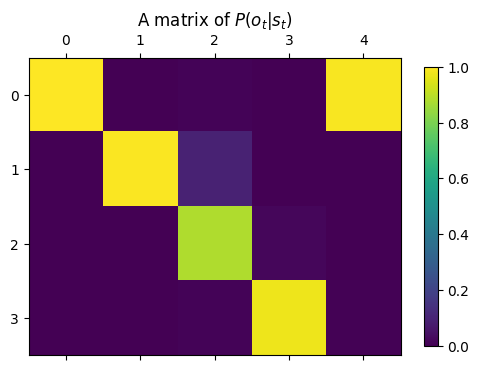

In [67]:
outs = [0, 1, 1, 3, 0] # the third note should have been 2, but the agent mistakenly played 1

D = np.asarray([1, 0, 0, 0])

prior = D #B[:,-1].dot(qs)

qs = softmax(np.asarray([0.5, 0.5, 0.5, 0.5])) 

n_iter = 100

qs_hist = np.zeros((n_iter * len(outs) + 1, 4))
qs_hist[0,:] = qs

dFdqs_list = []

# qs_hist = qs_hist.at[idx].set(y

vfe_hist = np.zeros(n_iter * len(outs) + 1)

out = np.zeros(4)
out[outs[0]] = 1

vfe_hist[0] = variational_free_energy(qs, out, A, prior)

learning_rate = 0.04 # learning rate to prevent gradient steps that are too big (overshooting)

qs_list = []

for state_index, output_note_index in enumerate(outs):
    
    out = np.zeros(4)
    out[output_note_index] = 1

    for i in range(state_index * n_iter, state_index * n_iter + n_iter):  

        dFdqs = grad_variational_free_energy(qs_hist[i,:], out, A, prior)

        dFdqs_list.append(learning_rate * dFdqs)


        ln_qs = jnp.log(qs_hist[i,:]) - learning_rate * dFdqs # transform qs to log-space to perform gradient descent

        print(i, ln_qs)
        # print(np.exp(dFdqs))
        qs_hist[i+1,:] = softmax(ln_qs) # re-normalize to make it a proper, categorical Q(s) again

        vfe_hist[i+1] = variational_free_energy(qs_hist[i+1,:], out, A, prior) # measure final variational free energy

        qs = qs_hist[i+1,:]

    # qs = softmax(log_joint_probability)

    # print("qs", qs)
    
    qs_list.append(qs)

    prior = B.dot(qs)



plt.matshow(np.asarray(qs_list).T, vmin = 0.0, vmax = 1.0)
plt.title("A matrix of $P(o_t | s_t)$")
plt.colorbar(shrink=0.75)
plt.show()

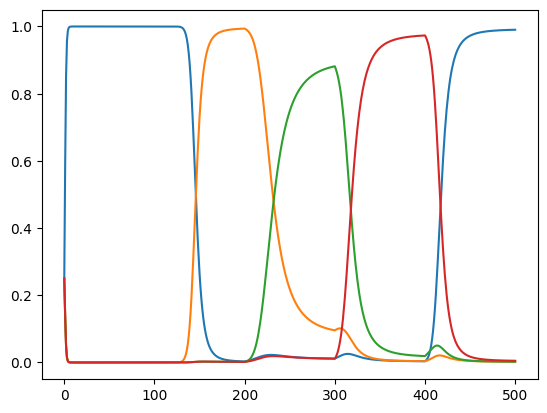

In [40]:
plt.plot(np.asarray(qs_hist))

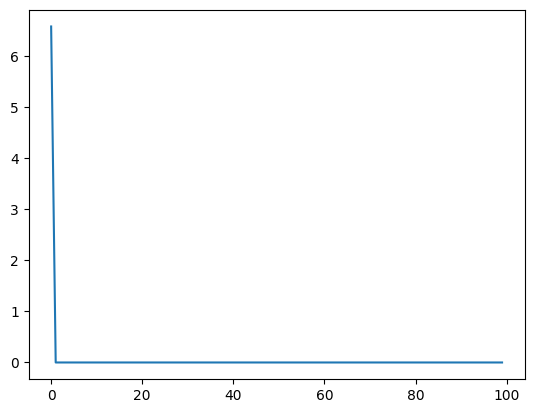

In [71]:
plt.plot(vfe_hist)

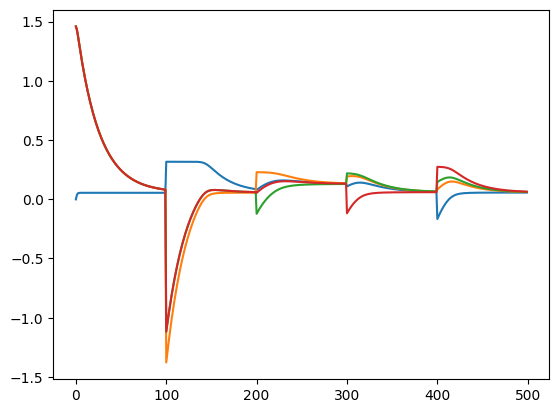

In [22]:
plt.plot(np.asarray(dFdqs_list))

In [23]:

outs = [0, 1, 1, 3, 0] # the third note should have been 2, but the agent mistakenly played 1
num_states = 4

log_joint_likelihood_seq = []
for t, obs_t in enumerate(outs):
    log_likelihood = np.ones(num_states) 
    log_likelihood = A[:, obs_t] # observation is an index thus we can use it to index the A matrix for the likelihood of the observation given the state
    log_joint_likelihood_seq.append(np.log(log_likelihood))

log_joint_likelihood_seq = np.asarray(log_joint_likelihood_seq)
log_joint_likelihood_seq

array([[-0.35667494, -2.30258509, -2.30258509, -2.30258509],
       [-2.30258509, -0.35667494, -2.30258509, -2.30258509],
       [-2.30258509, -0.35667494, -2.30258509, -2.30258509],
       [-2.30258509, -2.30258509, -2.30258509, -0.35667494],
       [-0.35667494, -2.30258509, -2.30258509, -2.30258509]])

In [24]:
qs_seq = np.ones((len(outs), num_states)) / num_states
qs_seq

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [25]:
# Marginal message passing

def compute_marginal_error(qs, log_joint_likelihood, log_B_past, log_B_future):
    neq_log_qs = 0.5 * (log_B_past + log_B_future) + log_joint_likelihood
    return jnp.sum(neq_log_qs - jnp.log(qs + eps_))

grad_compute_marginal_error = grad(compute_marginal_error)

B_T = softmax(B.T)

no_future_message = np.zeros(num_states)

num_factors = 4
for itr in range(10):
    for t in range(len(outs)):

        # print(log_joint_likelihood_seq[t], qs_seq[t])

        log_qs_t = np.log(qs_seq[t] + eps_)

        if t == 0:
            log_B_past = np.log(D + eps_)
        else:
            log_B_past = np.log(B.dot(qs_seq[t-1] + eps_))

        if t >= len(outs) - 1:
            log_B_future = no_future_message
        else:
            log_B_future = np.log(B_T.dot(qs_seq[t+1] + eps_))

        out = np.zeros(num_states)
        out[outs[t]] = 1

        error = .5 * (log_B_past + log_B_future) + np.log(A.T.dot(out)) - log_qs_t
        print("error: ", error, "total error: ", np.sum(error))
        v_t = log_qs_t + error * .1
        # print("v_t: ", v_t)
        qs_t = softmax(v_t)
        # print("qs_t: ", qs_t)
    
        qs_seq[t] = qs_t
        #softmax(neq_log_qs)

    # break


        # print("log_B_past", log_B_past)
        # print("log_B_future", log_B_future)
        # print("log_qs", log_qs)

        # log_A = np.log(np.dot(joint_likelihood_seq[t], qs_seq[t]) + eps_)
        # print(log_A)
            # print(spm_dot(joint_likelihood_seq[t], qs_seq[t], dims_to_omit=None))



error:  [  0.33647224 -20.03011866 -20.03011866 -20.03011866] total error:  -59.753883732538185
error:  [-2.76065839  0.15810387 -2.76065839 -2.76065839] total error:  -8.123871286110239
error:  [-2.34156082 -0.39565067 -2.2011261  -2.34156082] total error:  -7.279898405953384
error:  [-2.32927208 -2.32927208 -2.23572103 -0.37663448] total error:  -7.2708996803277
error:  [ 0.40410907 -1.63568009 -1.63568009 -1.63119884] total error:  -4.498449955758636
error:  [ -0.68694944 -19.06079478 -19.06079478 -19.06079478] total error:  -57.869333791975095
error:  [-3.28130021  0.07490561 -3.3100934  -3.3100934 ] total error:  -9.82658139579867
error:  [-2.34979337 -0.59580815 -2.03117293 -2.34979337] total error:  -7.326567818072383
error:  [-2.31145001 -2.31145001 -2.14271266 -0.50856057] total error:  -7.274173239539727
error:  [ 0.31384633 -1.60882878 -1.60882878 -1.59674023] total error:  -4.5005514539679305
error:  [ -0.91737181 -17.50853231 -17.50853231 -17.50817456] total error:  -53.44

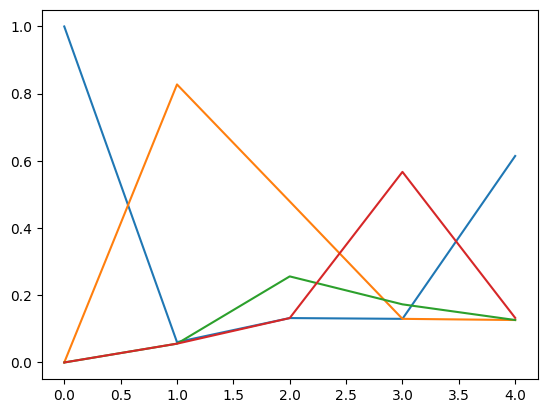

In [26]:
plt.plot(np.asarray(qs_seq))

In [27]:
np.asarray([
    [.9, .2],
    [.1, .8]
]).dot(np.asarray([.5, .5]))

array([0.55, 0.45])

In [28]:
def dot_likelihood(A,obs):

    s = np.ones(np.ndim(A), dtype = int)
    s[0] = obs.shape[0]
    X = A * obs.reshape(tuple(s))
    X = np.sum(X, axis=0, keepdims=True)
    LL = np.squeeze(X)

    # check to see if `LL` is a scalar
    if np.prod(LL.shape) <= 1.0:
        LL = LL.item()
        LL = np.array([LL]).astype("float64")

    return LL

def get_joint_likelihood(A, obs, num_states):
    # deal with single modality case
    if type(num_states) is int:
        num_states = [num_states]
    A = np.asarray(A)
    obs = np.asarray(obs)
    ll = np.ones(tuple(num_states))
    for modality in range(len(A)):
        ll = ll * dot_likelihood(A[modality], obs[modality])
    return ll

def get_joint_likelihood_seq(A, obs, num_states):
    ll_seq = np.empty(len(obs))
    for t, obs_t in enumerate(obs):
        ll_seq[t] = get_joint_likelihood(A, obs_t, num_states)
    return ll_seq

print(dot_likelihood(A, np.asarray([0, 1, 0, 0])))
print(np.dot(A, np.asarray([0, 1, 0, 0])))
# get_joint_likelihood([A], [0], 4)
# get_joint_likelihood_seq([[A]], [[outs]], [4])

[0.1 0.7 0.1 0.1]
[0.1 0.7 0.1 0.1]


In [29]:
num_factors = 2
for itr in range(10):
    for t in range(len(outs)):
        for f in range(num_factors):
            log_A = jnp.log(jnp.dot())

TypeError: dot() missing 2 required positional arguments: 'a' and 'b'

In [ ]:
dFdqs_list[0]

Array([-1.1847782e-03,  1.4582026e+00,  1.4582026e+00,  1.4582026e+00],      dtype=float32)

In [ ]:
import numpy as np
from scipy.special import softmax

# Generative model parameters
A = np.asarray([
    [7, 1, 1, 1],
    [1, 7, 1, 1],
    [1, 1, 7, 1],
    [1, 1, 1, 7],
]) / 10

B = np.asarray([
    [1, 1, 1, 97],
    [97, 1, 1, 1],
    [1, 97, 1, 1],
    [1, 1, 97, 1],
]) / 100

D = np.asarray([1, 0, 0, 0])
outs = [0, 1, 1, 3, 0]

# Initialize posterior beliefs over hidden states
num_states = A.shape[1]
num_timepoints = len(outs)

Q = np.ones((num_timepoints, num_states)) / num_states

# Set parameters for gradient descent
learning_rate = 0.1
epsilon = 1e-8  # Small value to avoid division by zero
num_iterations_per_time_step = 5  # Adjust as necessary

# Perform Variational Message Passing with multiple iterations per time step
for t in range(num_timepoints):
    obs_idx = outs[t]

    # Compute messages from the observation model
    ln_nu_A = np.log(A[obs_idx, :] + epsilon)

    # Initialize belief update
    if t == 0:
        ln_tilde_nu_B = np.log(D + epsilon)
    else:
        ln_tilde_nu_B = np.dot(Q[t-1, :], np.log(B + epsilon))

    if t == num_timepoints - 1:
        ln_tilde_nu_C = 0
    else:
        ln_tilde_nu_C = np.dot(Q[t+1, :], np.log(B.T + epsilon))

    # Perform multiple gradient descent iterations
    for _ in range(num_iterations_per_time_step):
        ln_Q_st = ln_nu_A + ln_tilde_nu_B + ln_tilde_nu_C
        Q[t, :] = softmax(ln_Q_st)

        # Compute the gradient
        gradient = ln_nu_A + ln_tilde_nu_B + ln_tilde_nu_C - np.log(Q[t, :] + epsilon)
        ln_Q_st += learning_rate * gradient
        Q[t, :] = softmax(ln_Q_st)

print("Posterior beliefs over time:")
print(Q)


Posterior beliefs over time:
[[9.99999997e-01 1.16036066e-09 1.16036066e-09 1.16036066e-09]
 [9.43397008e-03 6.60377909e-02 9.43397008e-03 9.15094269e-01]
 [1.79204021e-02 9.68248707e-02 8.71422602e-01 1.38321247e-02]
 [2.42995930e-02 8.40519053e-01 1.66230758e-02 1.18558278e-01]
 [9.88176824e-01 3.25719412e-03 5.19236993e-03 3.37361199e-03]]


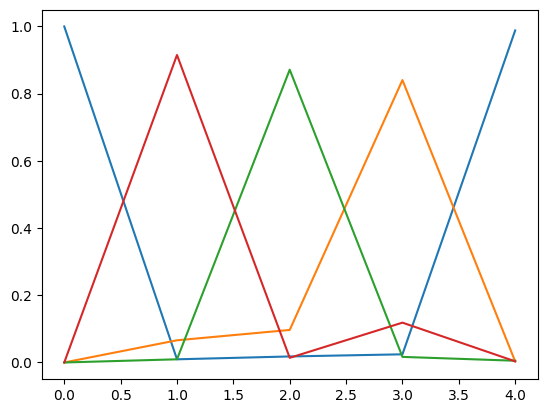

In [ ]:
plt.plot(Q)

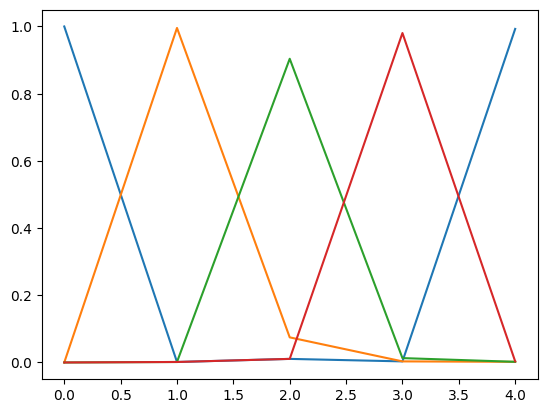

In [ ]:
qs_list
plt.plot(np.asarray(qs_list))

[]


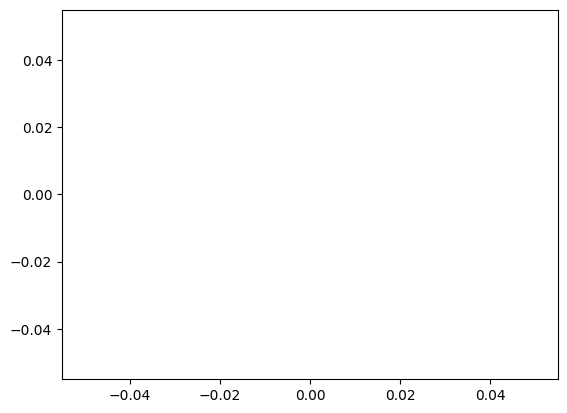

In [ ]:
print(qo_list)
plt.plot(np.asarray(qo_list))

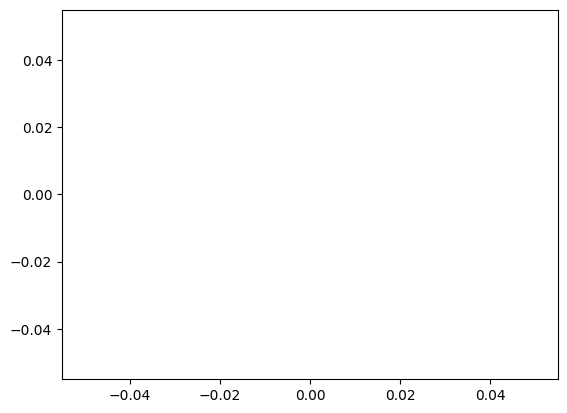

In [ ]:
plt.plot(np.asarray(free_e_list))

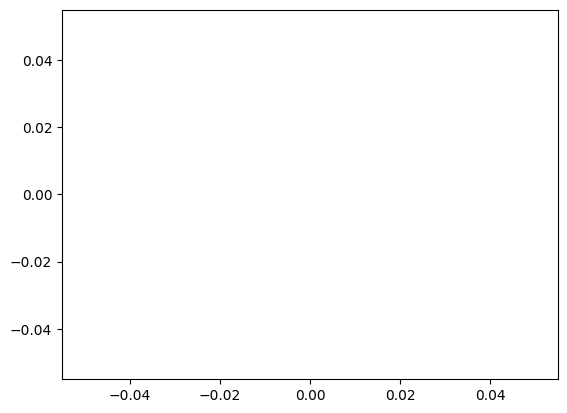

In [ ]:


plt.plot(np.asarray(prior_list))

In [ ]:
B[:,1]

array([0.01, 0.01, 0.97, 0.01])

In [ ]:
import itertools

grid_locations = list(itertools.product(range(3), repeat = 2))
print("grid_locations", grid_locations)

n_states = len(grid_locations)
n_observations = len(grid_locations)

A = np.zeros( (n_states, n_observations) )
np.fill_diagonal(A, 1.0)
print("A", A)

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B

B = create_B_matrix()
print("B", B)

""" Create an infer states function that implements the math we just discussed"""

def softmax(dist):
    """ 
    Computes the softmax function on a set of values
    """

    output = dist - dist.max(axis=0)
    output = np.exp(output)
    output = output / np.sum(output, axis=0)
    return output

def infer_states(observation_index, A, prior):
  eps_ = 1e-16
  """ Implement inference here -- NOTE: prior is already passed in, so you don't need to do anything with the B matrix. """
  """ This function has already been given P(s_t). The conditional expectation that creates "today's prior", using "yesterday's posterior", will happen *before calling* this function"""
  
  log_likelihood = np.log(A[observation_index,:] + eps_)

  log_prior = np.log(prior + eps_)

  qs = softmax(log_likelihood + log_prior)
   
  return qs

grid_locations [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
A [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
B [[[1. 0. 1. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]
  [1. 0. 0. 1. 1.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 1.]
  [0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1

In [ ]:
# qs_past = utils.onehot(4, n_states) # agent believes they were at location 4 -- i.e. (1,1) one timestep ago
qs_past = np.zeros(n_states)
qs_past[4] = 1

last_action = "UP" # the agent knew it moved "UP" one timestep ago
action_id = actions.index(last_action) # get the action index for moving "UP"
print("action_id", action_id, qs_past)

action_id 0 [0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
B[:,:,action_id]

array([[1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
prior = B[:,:,action_id].dot(qs_past)

observation_index = 2

print("prior", prior)
qs_new = infer_states(observation_index, A, prior)
print("qs_new", qs_new)


prior [0. 1. 0. 0. 0. 0. 0. 0. 0.]
qs_new [5.e-17 5.e-01 5.e-01 5.e-17 5.e-17 5.e-17 5.e-17 5.e-17 5.e-17]


In [ ]:
time_steps = 100
notes_count = 0
notes_played = []
next_node_index = choice(range(4), p=D)
prior = D
while notes_count < time_steps:
    # print(next_node_index)
    played_note = choice(range(4), p=A[:,next_node_index])
    notes_played.append(played_note)
    # print(played_note)
    next_node_index = choice(range(4), p=B[:,next_node_index])

    log_likelihood = np.log(A[played_note, next_node_index])

    log_prior = np.log(prior)

    qs

    prior = B[:, next_node_index] #* prior #FIXME: use dot instead?

    # qs = softmax(log_likelihood + log_prior)
    # prior = 
    # D = D @ A @ B
    # print(D)
    notes_count += 1


# plt.plot(notes_played)

ValueError: 'a' and 'p' must have same size

In [ ]:
qs

array([0.97, 0.01, 0.01, 0.01])

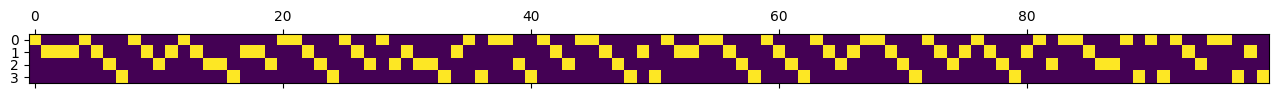

In [ ]:
matrix = np.zeros((A.shape[0], len(notes_played)))
# notes_played_indices = [(note, i) for i, note in enumerate(notes_played)]

for i, note in enumerate(notes_played):
    matrix[note, i] = 1

plt.matshow(matrix)
plt.show()


In [ ]:
# Posterior beliefs about each note in the sequence at each time step